# Importação das bibliotecas

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Carregamento, pré-processamento e análise exploratória dos dados

## Carregamento do conjunto de dados

In [28]:
data = pd.read_csv('data/olist_order_reviews_dataset.csv')
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Pré-processamento

In [29]:
def clean_data(data, column_text='review_comment_message',
               column_score='review_score',
               points_cut = [0, 2, 5],
               classes = [0, 1]):
  
  df_bin = data
  df_bin = df_bin.dropna(subset=[column_text])
  df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
  df_bin = df_bin.rename(columns={column_text: 'text'})
  df_bin = df_bin[['text', 'label']]

  df_cat = data
  df_cat = df_cat.dropna(subset=[column_text])
  df_cat = df_cat.rename(columns={column_text: 'text', column_score: 'label'})
  df_cat = df_cat[['text', 'label']]
  return df_bin, df_cat

data_bin, data_cat = clean_data(data)

In [30]:
data_bin

,text,label
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1
...,...,...
99205,para este produto recebi de acordo com a compr...,1
99208,Entregou dentro do prazo. O produto chegou em ...,1
99215,"O produto não foi enviado com NF, não existe v...",1
99221,"Excelente mochila, entrega super rápida. Super...",1


In [31]:
data_cat

,text,label
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5
9,aparelho eficiente. no site a marca do aparelh...,4
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
15,"Vendedor confiável, produto ok e entrega antes...",5
...,...,...
99205,para este produto recebi de acordo com a compr...,4
99208,Entregou dentro do prazo. O produto chegou em ...,5
99215,"O produto não foi enviado com NF, não existe v...",3
99221,"Excelente mochila, entrega super rápida. Super...",5


## Distribuição dos dados entre as classes

In [32]:
fig = px.bar(x = np.unique(data_cat['label']),
             y = [list(data_cat['label']).count(i) for i in np.unique(data_cat['label'])],
             color = np.unique(data_cat['label']),
             color_continuous_scale = 'Emrld')
fig.update_xaxes(title = 'Avaliação')
fig.update_yaxes(title = 'Número de avaliações')
fig.update_layout(showlegend = True,
  title = {
    'text': 'Avaliação vs Número de avaliações',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'

  })
fig.show()

In [33]:
fig = px.bar(x = np.unique(data_bin['label']),
             y = [list(data_bin['label']).count(i) for i in np.unique(data_bin['label'])],
             color = np.unique(data_bin['label']),
             color_continuous_scale = 'Emrld')
fig.update_xaxes(title = 'Classificação')
fig.update_yaxes(title = 'Número de avaliações')
fig.update_layout(showlegend = True,
  title = {
    'text': 'Avaliação vs Número de avaliações',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })
fig.show()

## Nuvem de palavras

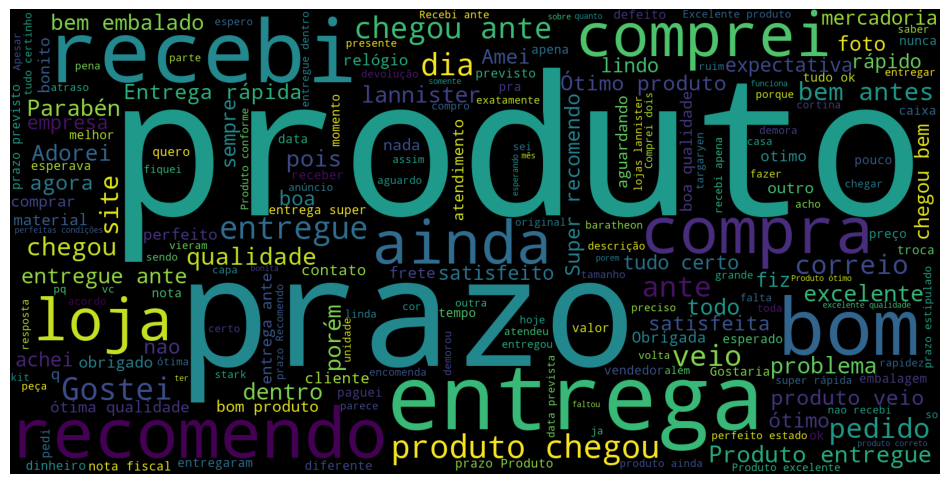

In [34]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords = stop_words,
                      background_color = 'black',
                      width = 1600, height = 800).generate(' '.join(data_bin['text']))
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

## Divisão dos dados em conjuntos de treino e teste

In [35]:
def split_test_train(data, split_train = 0.8, random_state = 12):
  df_train = data.sample(frac = split_train, random_state = random_state)
  df_test = data.drop(df_train.index)

  X_train = []
  y_train = []
  X_test = []
  y_test = []

  for index, train in df_train.iterrows():
    X_train.append(str(train['text']))
    y_train.append(train['label'])

  for index, test in df_test.iterrows():
    X_test.append(str(test['text']))
    y_test.append(test['label'])

  y_train = np.array(y_train)
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_test_train(data_bin, split_train = 0.8, random_state = 12)

## Tokenização e padding

In [36]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type = 'post', oov_tok = '<OOV>'):
  training_sequences = tokenizer.texts_to_sequences(X_train)
  X_train_padded = pad_sequences(training_sequences, maxlen = max_length, truncating = trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(X_test)
  X_test_padded = pad_sequences(testing_sequences, maxlen = max_length)

  return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, 120, 10000)

# Modelo de rede neural

## Definição do modelo

In [39]:
def create_model():
  input = tf.keras.Input(shape = (120))
  x = tf.keras.layers.Embedding(10000, 16, input_length = 120)(input)
  x = tf.keras.layers.LSTM(32, return_sequences = True)(x)
  x = tf.keras.layers.LSTM(32)(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(800, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(400, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  model = tf.keras.Model(input, output)

  return model

In [40]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                         patience = 3,
                                                         verbose = 1,
                                                         restore_best_weights = True)

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
  metrics = ['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 lstm_2 (LSTM)               (None, 120, 32)           6272      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 800)               26400     
                                                                 
 dropout_3 (Dropout)         (None, 800)               0   

## Treinamento do modelo

In [41]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 128,
                    callbacks = [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/25
257/257 [==============================] - 39s 137ms/step - loss: 0.5770 - accuracy: 0.7345 - val_loss: 0.5338 - val_accuracy: 0.7307
Epoch 2/25
257/257 [==============================] - 34s 133ms/step - loss: 0.5190 - accuracy: 0.7462 - val_loss: 0.5090 - val_accuracy: 0.7502
Epoch 3/25
257/257 [==============================] - 33s 129ms/step - loss: 0.4684 - accuracy: 0.7764 - val_loss: 0.3855 - val_accuracy: 0.8283
Epoch 4/25
257/257 [==============================] - 34s 131ms/step - loss: 0.3682 - accuracy: 0.8330 - val_loss: 0.3691 - val_accuracy: 0.8369
Epoch 5/25
257/257 [==============================] - 34s 131ms/step - loss: 0.3386 - accuracy: 0.8491 - val_loss: 0.3092 - val_accuracy: 0.8648
Epoch 6/25
257/257 [==============================] - 34s 133ms/step - loss: 0.3133 - accuracy: 0.8622 - val_loss: 0.3204 - val_accuracy: 0.8492
Epoch 7/25
257/257 [==============================] - 33s 128ms/step - loss: 0.2981 - accuracy: 0.8708 - val_loss: 0.2840 - val_ac

## Visualização dos resultados do treinamento

In [42]:
x = px.line(data_frame = history, y = ['accuracy', 'val_accuracy'], markers = True)
x.update_xaxes(title = 'Número de épocas', rangeslider_visible = True)
x.update_yaxes(title = 'Acurácia')
x.update_layout(showlegend = True,
  title = {
    'text': 'Acurácia vs Número de épocas',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })
x.show()

In [43]:
x = px.line(data_frame = history, y = ['loss', 'val_loss'], markers = True)
x.update_xaxes(title = 'Número de épocas', rangeslider_visible = True)
x.update_yaxes(title = 'Perda')
x.update_layout(showlegend = True,
  title = {
    'text': 'Perda vs Número de épocas',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })
x.show()

## Avaliação do modelo

In [46]:
y_preds_prob = model.predict(X_test, verbose = 0)
y_preds = np.where(y_preds_prob > 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss, accuracy] = model.evaluate(X_test, y_test, verbose = 0)
print("Acurácia no conjunto de teste: ", accuracy * 100, "%")
print(classification_report(y_test, y_preds))

Acurácia no conjunto de teste:  89.68883752822876 %
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2207
           1       0.94      0.92      0.93      5988

    accuracy                           0.90      8195
   macro avg       0.86      0.88      0.87      8195
weighted avg       0.90      0.90      0.90      8195



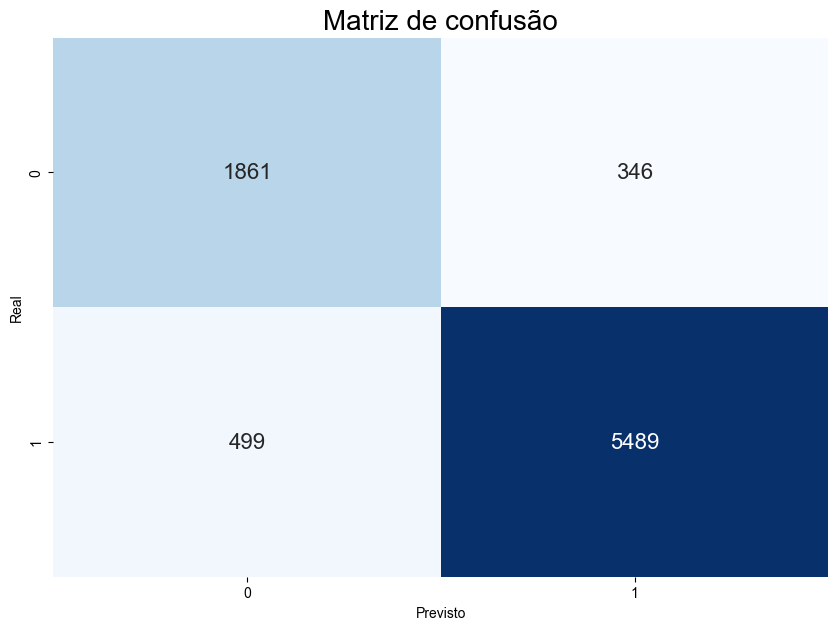

In [47]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns = [0, 1], index = [0, 1])
cm.index.name = 'Real'
cm.columns.name = 'Previsto'
plt.figure(figsize = (10, 7))
plt.title('Matriz de confusão', fontsize = 20)

sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, cbar = False, cmap = "Blues", annot = True, annot_kws = {'size': 16}, fmt = 'g')

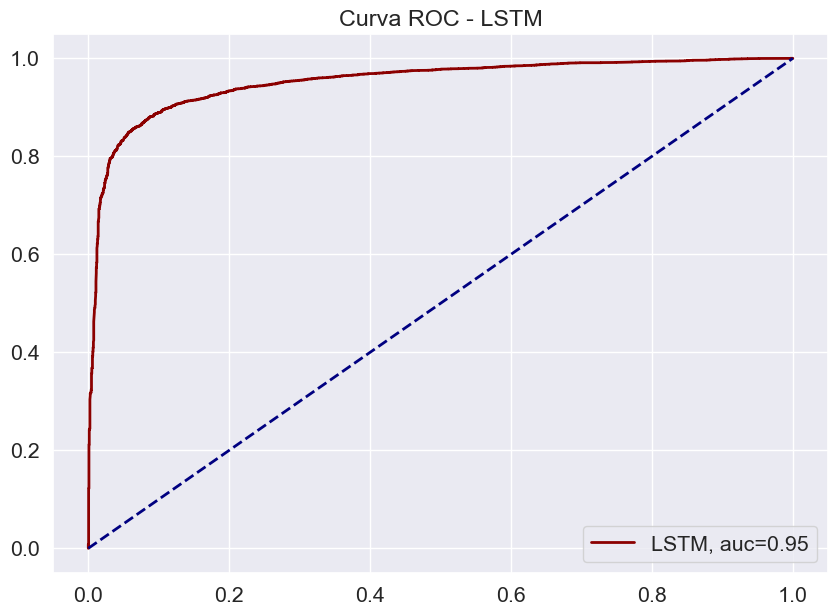

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10, 7))
plt.plot(fpr, tpr, color = 'darkred', lw = 2, label = "LSTM, auc=" + str(round(auc, 2)))
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.title('Curva ROC - LSTM')
plt.legend(loc = 4)
plt.show()

# Testando outros modelos de classificação

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Regressão logística

In [50]:
lr = LogisticRegression(max_iter = 10000, random_state = 12, n_jobs = 4)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Acurácia nos dados de treinamento = ", lr.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", lr.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  74.48904886828137 %
Acurácia nos dados de teste =  73.32519829164124 %


## Classificador Naive Bayes

In [53]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)
print("Acurácia nos dados de treinamento = ", nb.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", nb.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  74.55615886767129 %
Acurácia nos dados de teste =  74.35021354484441 %


## Classificador SVC

In [54]:
svm = SVC(random_state = 12, verbose = True)
svm.fit(X_train, y_train)
sv_preds = svm.predict(X_test)
print("Acurácia nos dados de treinamento = ", svm.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", svm.score(X_test, y_test) * 100, "%")

[LibSVM]Acurácia nos dados de treinamento =  79.7907388200842 %
Acurácia nos dados de teste =  74.49664429530202 %


## Classificador Random Forest

In [55]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 12, n_jobs = 4)
rfc.fit(X_train, y_train)
rf_preds = rfc.predict(X_test)
print("Acurácia nos dados de treinamento = ", rfc.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", rfc.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  99.5790372765542 %
Acurácia nos dados de teste =  78.40146430750458 %


## Classificador XGBoost

In [56]:
xgb = XGBClassifier(objective = 'binary:logistic',
                    use_label_encoder = False,
                    random_state = 12,
                    eval_metric = 'mlogloss')
xgb.fit(X_train, y_train)
xg_preds = xgb.predict(X_test)
print("Acurácia nos dados de treinamento = ", xgb.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", xgb.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  92.96870233664816 %
Acurácia nos dados de teste =  83.01403294691885 %


# Comparação das performances

## Acurácia no conjunto de teste

In [64]:
results = pd.DataFrame(data = [accuracy * 100], columns = ["Rede neural - LSTM"], index = ["Acurácia"])
results['Regressão logística'] = lr.score(X_test, y_test) * 100
results['Classificador Naive Bayes'] = nb.score(X_test, y_test) * 100
results['Classificador SVC'] = svm.score(X_test, y_test) * 100
results['Classificador Random Forest'] = rfc.score(X_test, y_test) * 100
results['Classificador XGBoost'] = xgb.score(X_test, y_test) * 100
results = results.transpose()

In [71]:
x = px.bar(results, y = 'Acurácia', text_auto = True)
x.update_xaxes(title = 'Modelo', categoryorder = 'total descending')
x.update_yaxes(title = 'Acurácia (%)')
x.update_layout(showlegend = True,
  title = {
    'text': 'Acurácia do modelo no conjunto de teste',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })        

x.show()

## Comparação das matrizes de confusão

<AxesSubplot: title={'center': 'Classificador XGBoost'}>

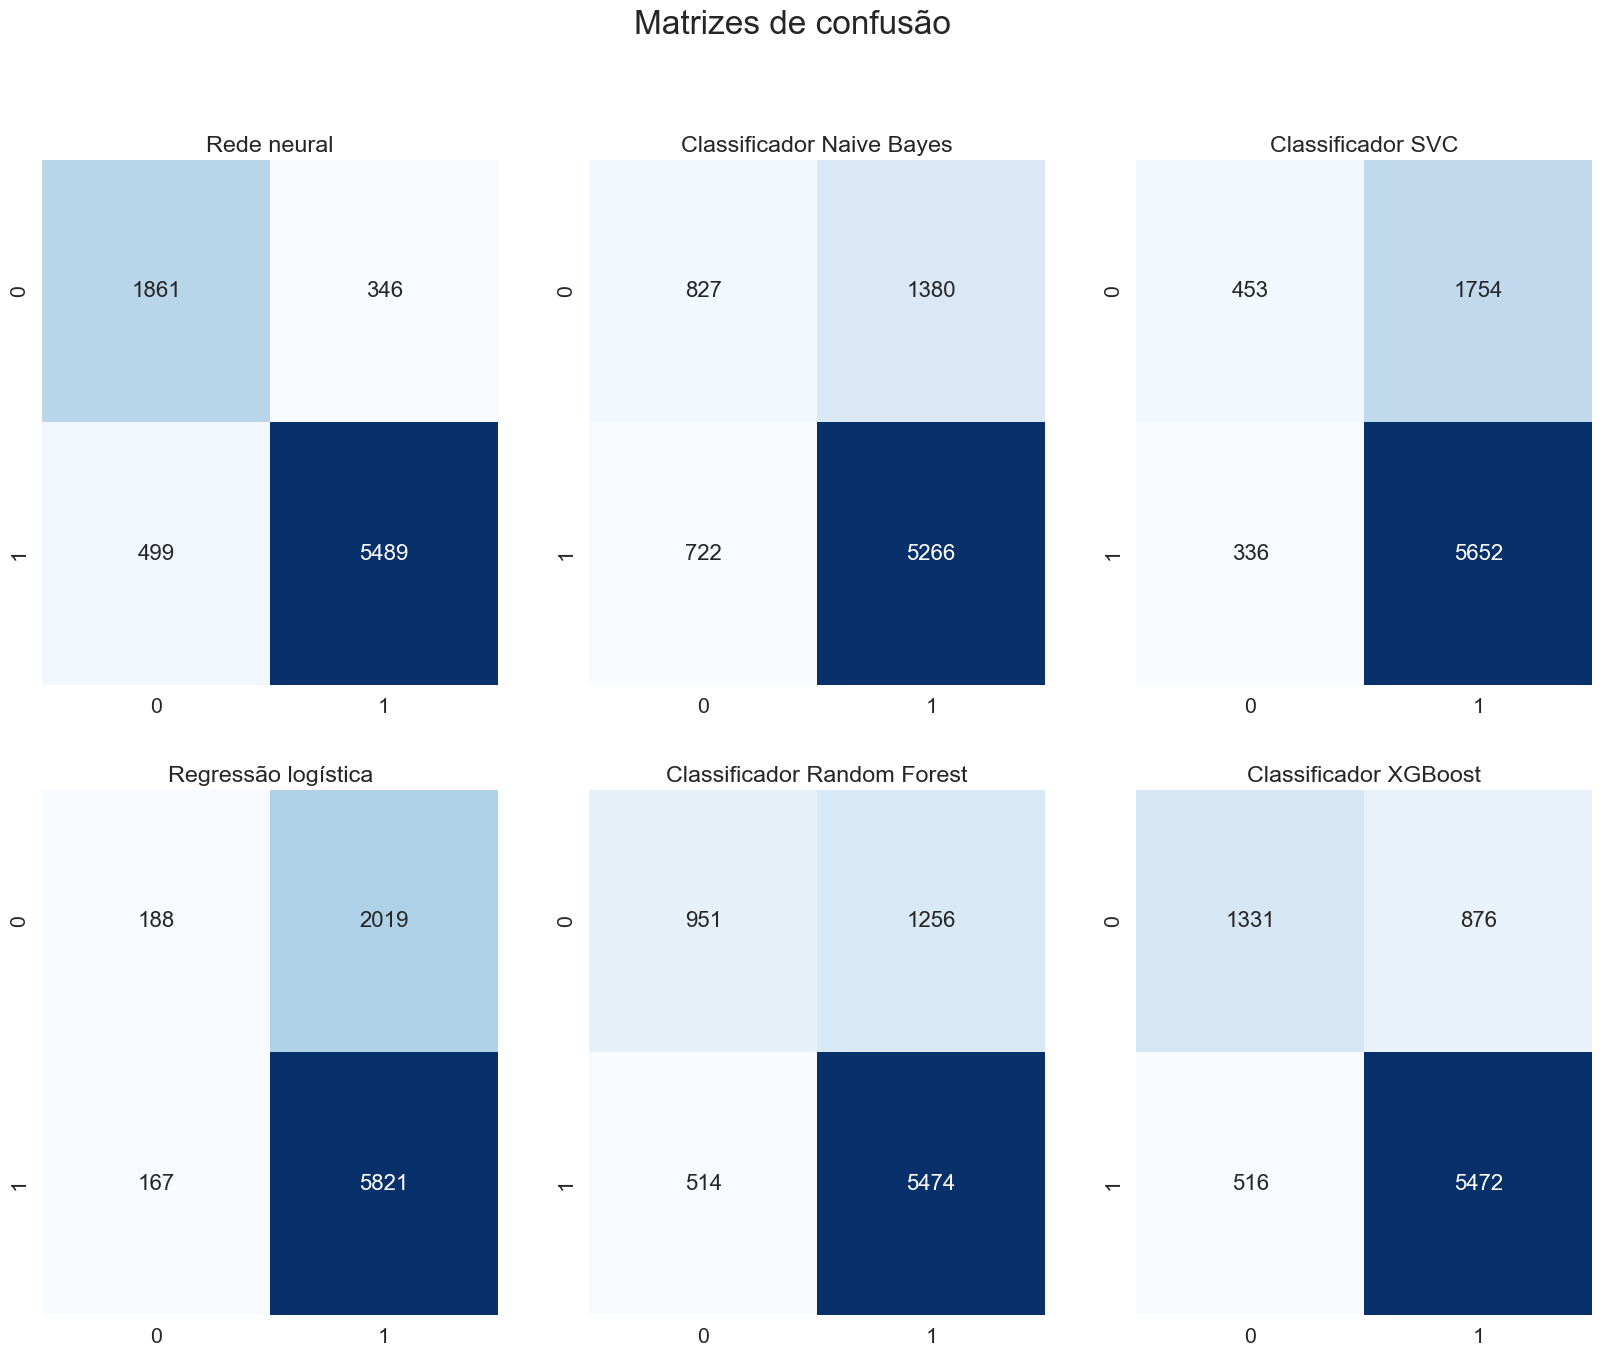

In [78]:
lr_cm = confusion_matrix(y_test, lr_preds)
nb_cm = confusion_matrix(y_test, nb_preds)
svm_cm = confusion_matrix(y_test, sv_preds)
nn_cm = confusion_matrix(y_test, y_preds)
rf_cm = confusion_matrix(y_test, rf_preds)
xg_cm = confusion_matrix(y_test, xg_preds)

plt.figure(figsize = (20, 15))
plt.suptitle('Matrizes de confusão', fontsize = 24)

plt.subplot(2, 3, 1)
plt.title('Rede neural')
sns.heatmap(nn_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 2)
plt.title('Classificador Naive Bayes')
sns.heatmap(nb_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 3)
plt.title('Classificador SVC')
sns.heatmap(svm_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 4)
plt.title('Regressão logística')
sns.heatmap(lr_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 5)
plt.title('Classificador Random Forest')
sns.heatmap(rf_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 6)
plt.title('Classificador XGBoost')
sns.heatmap(xg_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

## Comparação das curvas ROC

In [82]:
from sklearn.metrics import auc

pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

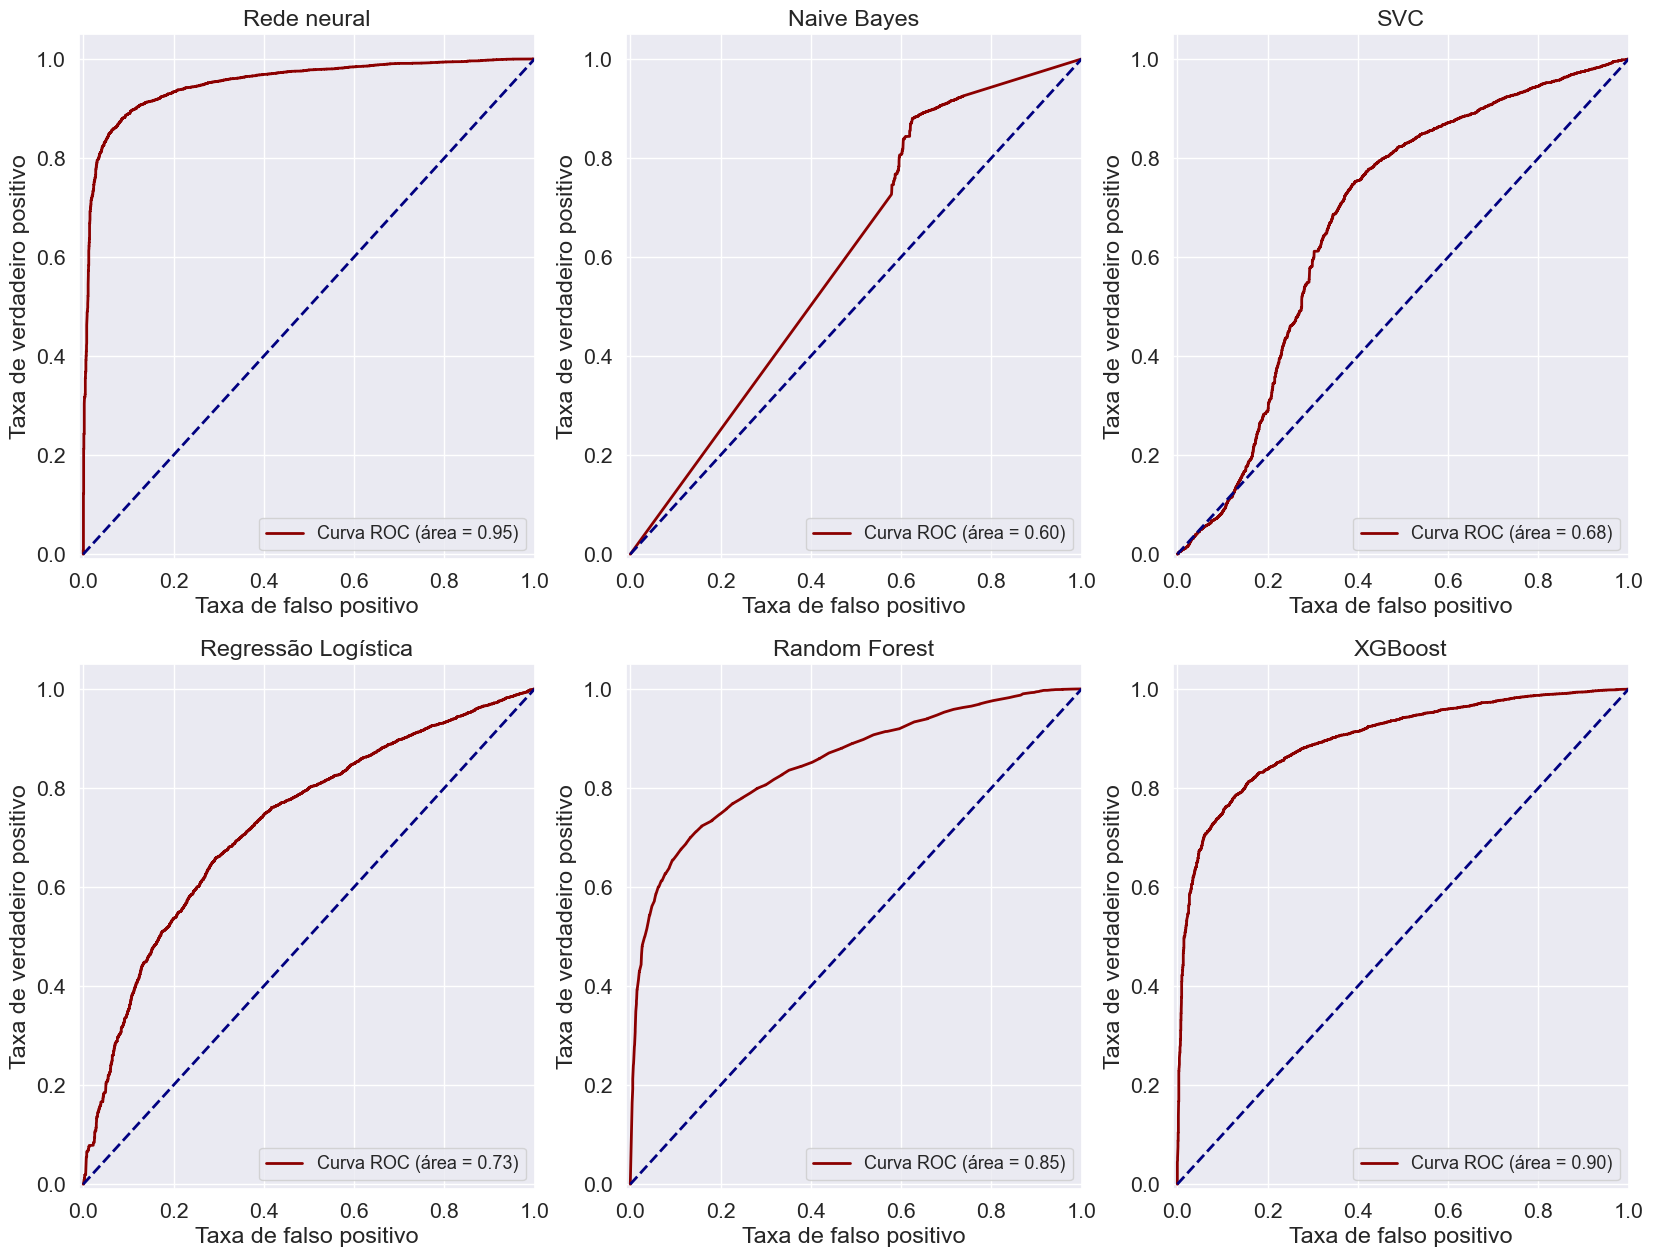

In [91]:
f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Rede neural')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'SVC')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Regressão Logística')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Random Forest')
axes[1,1].legend(loc='lower right', fontsize=13)

axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'XGBoost')
axes[1,2].legend(loc='lower right', fontsize=13)
